### Extra Trees Classifier

For each tree, at each stage, the best split result from all randomized split is selected.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.model_selection import ParameterGrid
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import StratifiedKFold
import re, string, time
from nltk.stem.snowball import SnowballStemmer
from sklearn.metrics import log_loss

Custom functions for loading and preprocessing data.

In [2]:
def most_freq_vects(docs, max_feature=None, percent=None, token_pattern=u'(?u)\b\w\w+\b'):
    vect = CountVectorizer(token_pattern=token_pattern)
    feat_sparse = vect.fit_transform(docs.values.astype('U'))
    freq_table = list(zip(vect.get_feature_names(), np.asarray(feat_sparse.sum(axis=0)).ravel()))
    freq_table = pd.DataFrame(freq_table, columns=['feature', 'count']).sort_values('count', ascending=False)
    if not max_feature:
        if percent:
            max_feature = int(percent * len(vect.get_feature_names()))
        else:
            max_feature = len(vect.get_feature_names())
    feat_df = pd.DataFrame(feat_sparse.todense(), columns=vect.get_feature_names())
    names = list(freq_table.feature[:max_feature])
    return feat_df[names]


def load_data():
    print('Loading features files')
    basic_feat = pd.read_json('../feat_input/basic_feat.json')
    longtime_feat = pd.read_csv('../feat_input/longtime_feat.csv')
    encoded_feat = pd.read_csv('../feat_input/feat_stats_encoding.csv')

    # apply ordinal encoding to categorical feature
    print('Ordinal encoding')
    basic_feat.display_address = basic_feat.display_address.replace(r'\r$', '', regex=True)
    basic_feat.street_address = basic_feat.street_address.replace(r'\r$', '', regex=True)
    categorical = ["display_address", "manager_id", "building_id", "street_address"]
    for f in categorical:
        if basic_feat[f].dtype == 'object':
            lbl = preprocessing.LabelEncoder()
            lbl.fit(list(basic_feat[f].values))
            basic_feat[f] = lbl.transform(list(basic_feat[f].values))

    all_feat = basic_feat.merge(longtime_feat, on='listing_id')
    all_feat = all_feat.merge(encoded_feat, on='listing_id')

    print("Features document-term matrix")
    stemmer = SnowballStemmer('english')
    punct = string.punctuation
    punct = re.sub("'|-", "", punct)
    pattern = r"[0-9]|[{}]".format(punct)
    all_feat['features'] = all_feat['features'].apply(lambda x: [re.sub(pattern, "", y) for y in x])
    all_feat['features'] = all_feat['features'].apply(lambda x: [stemmer.stem(y) for y in x])
    all_feat['features'] = all_feat['features'].apply(lambda x: ['_'.join(['feature'] + y.split()) for y in x])
    all_feat['features'] = all_feat['features'].apply(lambda x: ' '.join(x))
    vect_df = most_freq_vects(all_feat['features'], max_feature=100, token_pattern=r"[^ ]+")
    
    all_feat = pd.concat([all_feat, vect_df], axis=1)
    train = all_feat[all_feat.interest_level != -1].copy()
    test = all_feat[all_feat.interest_level == -1].copy()
    y_train=train["interest_level"]

    x_train = train.drop(["interest_level","features"],axis=1)
    x_test = test.drop(["interest_level","features"],axis=1)

    return x_train, y_train, x_test, x_test.columns.values, x_test.listing_id


def _preprocess(dtrain, dtest):
    # replace np.inf to np.nan
    dtrain = dtrain.replace([np.inf, -np.inf], np.nan)
    dtest = dtest.replace([np.inf, -np.inf], np.nan)

    # impute np.nan
    dtrain_col_mean = dtrain.mean(axis=0)
    dtrain, dtest = dtrain.fillna(dtrain_col_mean), dtest.fillna(dtrain_col_mean)

    # perform standardization
    dtrain_col_mean, dtrain_col_std = dtrain.mean(axis=0), dtrain.std(axis=0)
    dtrain, dtest = map(lambda x: (x - dtrain_col_mean) / dtrain_col_std, (dtrain, dtest))

    return dtrain, dtest


def _preprocess_log(dtrain, dtest):
    # replace np.inf to np.nan
    dtrain = dtrain.replace([np.inf, -np.inf], np.nan)
    dtest = dtest.replace([np.inf, -np.inf], np.nan)

    # impute np.nan
    dtrain_col_mean = dtrain.mean(axis=0)
    dtrain, dtest = dtrain.fillna(dtrain_col_mean), dtest.fillna(dtrain_col_mean)

    # log transform of min-zero columns
    dtrain_col_min = dtrain.min(axis=0)
    zero_min_index = dtrain_col_min[dtrain_col_min >= 0].index

    dtrain[zero_min_index] = np.log10(dtrain[zero_min_index] + 1.0)
    dtest[zero_min_index] = np.log10(dtest[zero_min_index] + 1.0)

    # perform standardization
    dtrain_col_mean, dtrain_col_std = dtrain.mean(axis=0), dtrain.std(axis=0)
    dtrain, dtest = map(lambda x: (x - dtrain_col_mean) / dtrain_col_std, (dtrain, dtest))

    return dtrain, dtest

Train model with 5-fold cv. Output train and test multi-logloss as a measure of performance.

In [3]:
def run_model(dtrain, dtest=None):
    params = {'max_features': 'sqrt',
              'criterion': 'entropy',
              'max_depth': None,
              'n_estimators': 2000,
              'bootstrap': True,
              'oob_score': True,
              'n_jobs': -1,
              'verbose': 1,
              'random_state': 36683
              }
    clf = ExtraTreesClassifier()
    clf.set_params(**params)
    if dtest:
        clf.fit(dtrain[0], dtrain[1])
        y_train_pred, y_test_pred = clf.predict_proba(dtrain[0]), clf.predict_proba(dtest[0])
        y_train_loss, y_test_loss = log_loss(dtrain[1], y_train_pred), log_loss(dtest[1], y_test_pred)
        return clf, y_train_loss, y_test_loss
    else:
        clf.fit(dtrain[0], dtrain[1])
        y_train_pred = clf.predict_proba(dtrain[0])
        y_train_loss = log_loss(dtrain[1], y_train_pred)
        return clf, y_train_loss

In [4]:
def train_cv(preprocess='linear'):
    X_train, y_train_cls, X_test, _, _ = load_data()
    if preprocess == 'log':
        X_train, X_test = _preprocess_log(X_train, X_test)
    else:
        X_train, X_test = _preprocess(X_train, X_test)

    cv_scores, n_folds = [], 5
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=816)
    for i, (train_ind, val_ind) in enumerate(skf.split(X_train, y_train_cls)):
        print("Running Fold", i + 1, "/", n_folds)
        start = time.time()
        
        train_x, val_x = X_train.iloc[train_ind, :], X_train.iloc[val_ind, :]
        train_y, val_y = y_train_cls.iloc[train_ind], y_train_cls.iloc[val_ind]
        clf, train_loss, val_loss = run_model((train_x, train_y), (val_x, val_y))
        cv_scores.append([train_loss, val_loss])
        
        print("train_loss: {0:.6f}, val_loss: {1:.6f}".format(train_loss, val_loss), end="\t")
        
        end = time.time()
        m, s = divmod(end-start, 60)
        h, m = divmod(m, 60)
        print("time elapsed: %d:%02d:%02d" % (h, m, s))
        
    mean_train_loss = np.mean([cv_scores[i][0] for i in range(len(cv_scores))])
    mean_val_loss = np.mean([cv_scores[i][1] for i in range(len(cv_scores))])
    print("train_loss mean: {0:.6f}, val_loss mean: {1:.6f}".format(mean_train_loss, mean_val_loss))

In [5]:
train_cv(preprocess='linear')

Loading features files
Ordinal encoding
Features document-term matrix
Running Fold 1 / 5


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:   36.9s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:   51.4s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   56.9s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:    6.4s
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:    7.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:

train_loss: 0.144826, val_loss: 0.573288	time elapsed: 0:01:34
Running Fold 2 / 5


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   51.8s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:    6.4s
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:    7.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:

train_loss: 0.145397, val_loss: 0.566895	time elapsed: 0:01:29
Running Fold 3 / 5


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:   41.5s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   46.3s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    4.1s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:    6.1s
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:   10.6s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:

train_loss: 0.145555, val_loss: 0.567564	time elapsed: 0:01:30
Running Fold 4 / 5


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   47.2s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:    6.1s
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:    6.9s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:

train_loss: 0.144959, val_loss: 0.571136	time elapsed: 0:01:28
Running Fold 5 / 5


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:   41.1s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   45.9s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    4.7s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    8.4s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:   28.0s
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:   36.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:

train_loss: 0.145160, val_loss: 0.570817	time elapsed: 0:02:24
train_loss mean: 0.145179, val_loss mean: 0.569940


In [6]:
train_cv(preprocess='log')

Loading features files
Ordinal encoding
Features document-term matrix
Running Fold 1 / 5


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   43.5s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:    6.1s
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:    6.8s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:

train_loss: 0.143007, val_loss: 0.570683	time elapsed: 0:01:20
Running Fold 2 / 5


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   48.9s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    6.4s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:   17.0s
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:   24.6s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:

train_loss: 0.143596, val_loss: 0.559216	time elapsed: 0:02:05
Running Fold 3 / 5


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:   44.9s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   50.6s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    8.1s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:   14.5s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:   23.8s
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:   28.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:

train_loss: 0.143784, val_loss: 0.560428	time elapsed: 0:02:05
Running Fold 4 / 5


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:   53.3s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  1.1min finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    7.7s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:   16.2s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:   31.3s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:   57.6s
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:  1.1min finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:

train_loss: 0.143279, val_loss: 0.564481	time elapsed: 0:03:52
Running Fold 5 / 5


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:   52.8s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   58.6s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:   11.4s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:   55.6s
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:  2.3min finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:

train_loss: 0.143292, val_loss: 0.563075	time elapsed: 0:04:59
train_loss mean: 0.143392, val_loss mean: 0.563577


Plot feature importance.

In [7]:
def _feature_importance(feat_names, importance):
    feat_importances = pd.DataFrame({'feature': feat_names, 'importance': importance})
    feat_importances = feat_importances.sort_values(by='importance', ascending=False)
    print(feat_importances)

    plt.style.use('ggplot')
    plt.figure()
    feat_importances = feat_importances.sort_values(by='importance', ascending=True)
    feat_importances.plot(kind='barh', x='feature', y='importance', legend=False, figsize=(10, 50))
    plt.title('Ramdom Forest Feature Importance')
    plt.xlabel('relative importance')
    plt.tight_layout()
    plt.show()

Loading features files
Ordinal encoding
Features document-term matrix


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  1.5min finished


OOB error: 0.253
                                  feature  importance
30                            jwd_type_rt    0.039811
6                             building_id    0.026236
28                  jwd_type_low_than_num    0.024845
90           price_manager_id_mean_pred_1    0.024735
91           price_manager_id_mean_pred_2    0.022717
27                             time_stamp    0.021443
22                                  price    0.019254
89           price_manager_id_mean_pred_0    0.018012
88                        manager_id_high    0.017980
87                      manager_id_medium    0.017854
8                            created_hour    0.017299
16                         img_sizes_mean    0.016339
86                         manager_id_low    0.015974
23                          price_bath_rt    0.015820
25                          price_room_rt    0.014912
18                             listing_id    0.014246
31                      building_zero_num    0.013793
7          

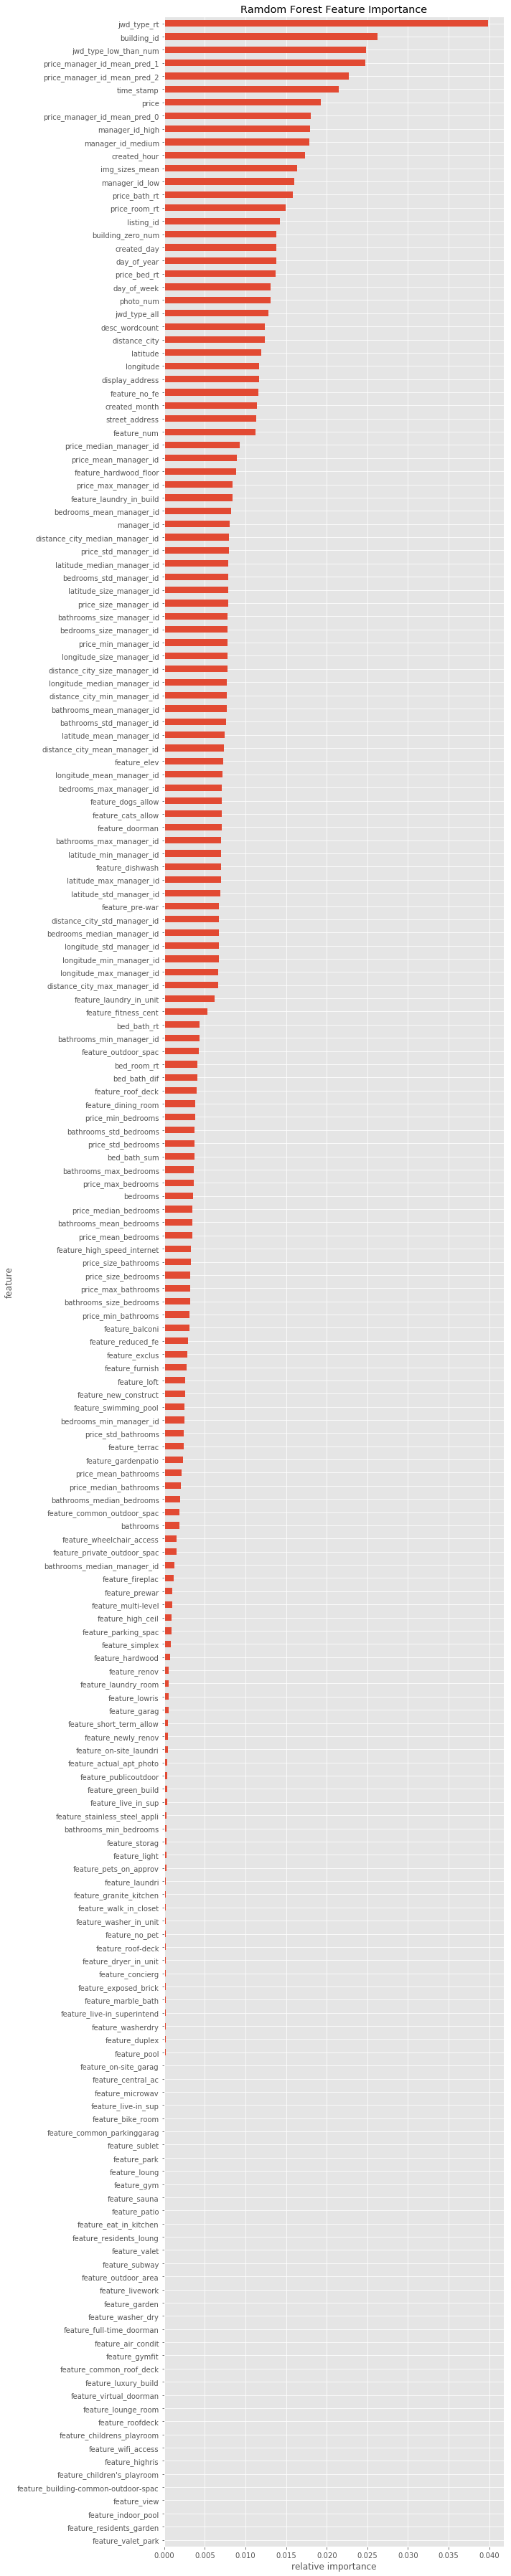

In [8]:
X_train, y_train_cls, X_test, feat_names, listing_id = load_data()
X_train, X_test = _preprocess_log(X_train, X_test)

params = {'max_features': 'sqrt',
          'criterion': 'entropy',
          'max_depth': None,
          'n_estimators': 2000,
          'bootstrap': True,
          'oob_score': True,
          'n_jobs': -1,
          'verbose': 1,
          'random_state': 36683
         }
clf = ExtraTreesClassifier()
clf.set_params(**params)
clf.fit(X_train, y_train_cls)
print('OOB error: {0:.3f}'.format(1-clf.oob_score_))

# feature importance
_feature_importance(feat_names, clf.feature_importances_)

The ET classifier performs a little bit worse compared with Random forest classifier, and it definitely requests more memory (about 85% of 12gb). The results shown above still indicates they have pretty similar predictions.